# Variação de seção do poço


Arquivo de configuração


In [2]:
from modules.simulation.config.model import SimulationConfigModel
import pathlib

case_data = {
    "poco_reto": {"title": "Poço reto"},
    "2_fases": {"title": "2 fases"},
    "4_fases": {"title": "4 fases"},
}

for case in case_data.keys():
    cfg_path = pathlib.Path(f"./docs/source/_static/software/{case}.yaml")
    cfg = SimulationConfigModel.from_file(cfg_path)
    case_data[case]["cfg"] = cfg.model_copy()

case_data

{'poco_reto': {'title': 'Poço reto',
  'cfg': SimulationConfigModel(sim_name='poco_reto', domain=DomainModel(height=0.21, spatial_divisions=220, annular_domain=AnnularDomainModel(internal_radius=0.01, steps=[StepModel(position_z=0.05, radius=0.02)])), suspension=SuspensionModel(initial_conc=0.1391, max_conc=0.19), solid_phase=SolidPhaseModel(particle_diam=4.08e-05, particle_esphericity=0.8, density=2709.0), fluid_phase=FluidPhaseModel(density=891.4, power_law=PowerLawFluidModel(M=30.13, n=0.21)), simulation_parameters=SimulationParameters(timestep=1000.0, total_time=31536000.0), export=FrequencyConfig(frequency=100), report=FrequencyConfig(frequency=1000), HPHT=None, equation_parameters=EquationParameters(delta=0.622641, k0=47.601104, beta=0.04983, ref_conc=0.14, p_ref=63.640954))},
 '2_fases': {'title': '2 fases',
  'cfg': SimulationConfigModel(sim_name='2_fases', domain=DomainModel(height=0.21, spatial_divisions=220, annular_domain=AnnularDomainModel(internal_radius=0.01, steps=[Step

Run simulations


In [29]:
import time
from modules.simulation.sim_handler import SimulationHandler

for case in case_data.keys():
    cfg = case_data[case]["cfg"]
    output_path = pathlib.Path(f"./out/{cfg.sim_name}")
    sim_handler = SimulationHandler(cfg=cfg, output_path=output_path)
    start = time.time()

    sim_handler.start_simulation()

    end = time.time()

    print("\nTempo total de simulação:" + str(end - start) + " [s]")
    print("Status da simulação: " + sim_handler.sim_status)
    print("Exportando resultados...")

    sim_handler.export_sim_data()
    sim_handler.export_domain_polydata(frequency_reduction=100)

[2024-09-08 23:55:05,005] [INFO] - simulation - Starting simulation... (sim_handler.py:87)
[2024-09-08 23:55:05,006] [INFO] - simulation - Current time 0 (sim_handler.py:88)
[2024-09-08 23:55:05,752] [INFO] - simulation - Simulation report: Current time 1000000.0 (sim_handler.py:73)
[2024-09-08 23:55:05,753] [INFO] - simulation - Mass conservation report: Deviation 3.48E-06% (sim_handler.py:61)
[2024-09-08 23:55:06,499] [INFO] - simulation - Simulation report: Current time 2000000.0 (sim_handler.py:73)
[2024-09-08 23:55:06,500] [INFO] - simulation - Mass conservation report: Deviation 3.48E-06% (sim_handler.py:61)
[2024-09-08 23:55:07,296] [INFO] - simulation - Simulation report: Current time 3000000.0 (sim_handler.py:73)
[2024-09-08 23:55:07,297] [INFO] - simulation - Mass conservation report: Deviation 3.48E-06% (sim_handler.py:61)
[2024-09-08 23:55:08,089] [INFO] - simulation - Simulation report: Current time 4000000.0 (sim_handler.py:73)
[2024-09-08 23:55:08,090] [INFO] - simulatio

## Read simulation data


In [3]:
from modules.analysis.results_handler import ResultsHandler
import pathlib

for case in case_data.keys():
    cfg = case_data[case]["cfg"]
    output_path = pathlib.Path(f"./out/{cfg.sim_name}")
    results_handler = ResultsHandler(simulation_path=output_path)
    case_data[case]["results_handler"] = results_handler

Plot concentration


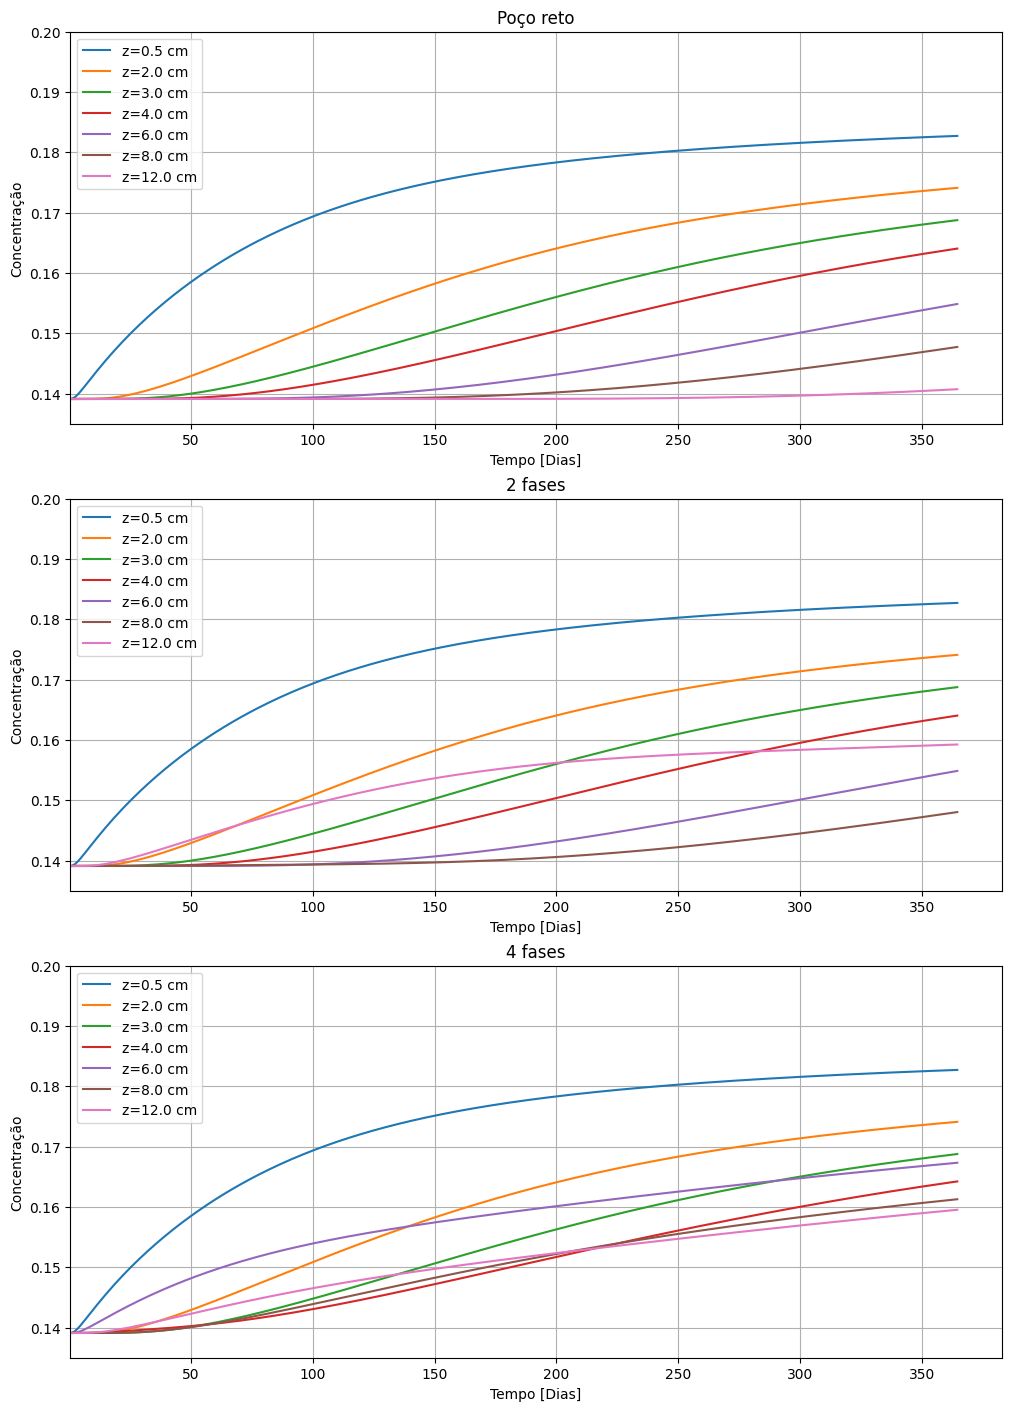

In [4]:
import matplotlib.pyplot as plt

target_positions = [0.005, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12]

fig, axs = plt.subplots(
    min(3, len(case_data)),
    min(1, (len(case_data) - 1) // 3 + 1),
    figsize=(10, 14),
    layout="constrained",
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]
    time, concentration_profiles = results_handler.filter_for_positions(
        variable_name="Concentration", position_values=target_positions
    )

    for position_lbl, concentration_arr in concentration_profiles.items():
        ax.plot(time / (3600 * 24), concentration_arr, label=position_lbl)

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Tempo [Dias]")
    ax.set_xlim(0.400)
    ax.set_ylabel("Concentração")
    ax.set_ylim(0.135, 0.2)
    ax.grid()

    ax.legend()
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_20824\2013268098.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("viridis")


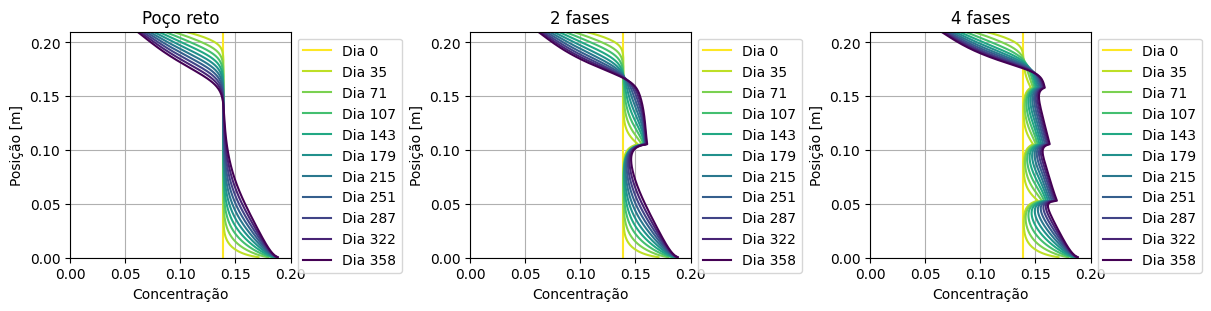

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.colors import Normalize

N_DIVS = 10

target_timeframes = (
    case_data[[k for k in case_data.keys()][0]]["results_handler"]
    .cell_data["Time"]
    .unique()
)
target_timeframes = target_timeframes[:: len(target_timeframes) // N_DIVS]

fig, axs = plt.subplots(1, 3, figsize=(12, 3), layout="constrained")

num_colors = len(target_timeframes)
# colormap = cm.get_cmap("summer")
colormap = cm.get_cmap("viridis")
# colormap = cm.get_cmap("cool")
normalize = Normalize(vmin=0, vmax=num_colors - 1)
color_array = [colormap(normalize(i)) for i in range(num_colors)]
color_array = color_array[::-1]

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]
    for i, t_time in enumerate(target_timeframes):
        df = results_handler.cell_data
        X = df["Concentration"].loc[df["Time"] == t_time]
        Y = df["Position"].loc[df["Time"] == t_time]
        ax.plot(X, Y, label=f"Dia {int(t_time / (24 * 60 * 60))}", color=color_array[i])

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Concentração")
    ax.set_xlim(0, 0.2)
    ax.set_ylabel("Posição [m]")
    ax.set_ylim(0, 0.21)
    ax.grid()
    ax.legend(bbox_to_anchor=(1, 1))

plt.show()

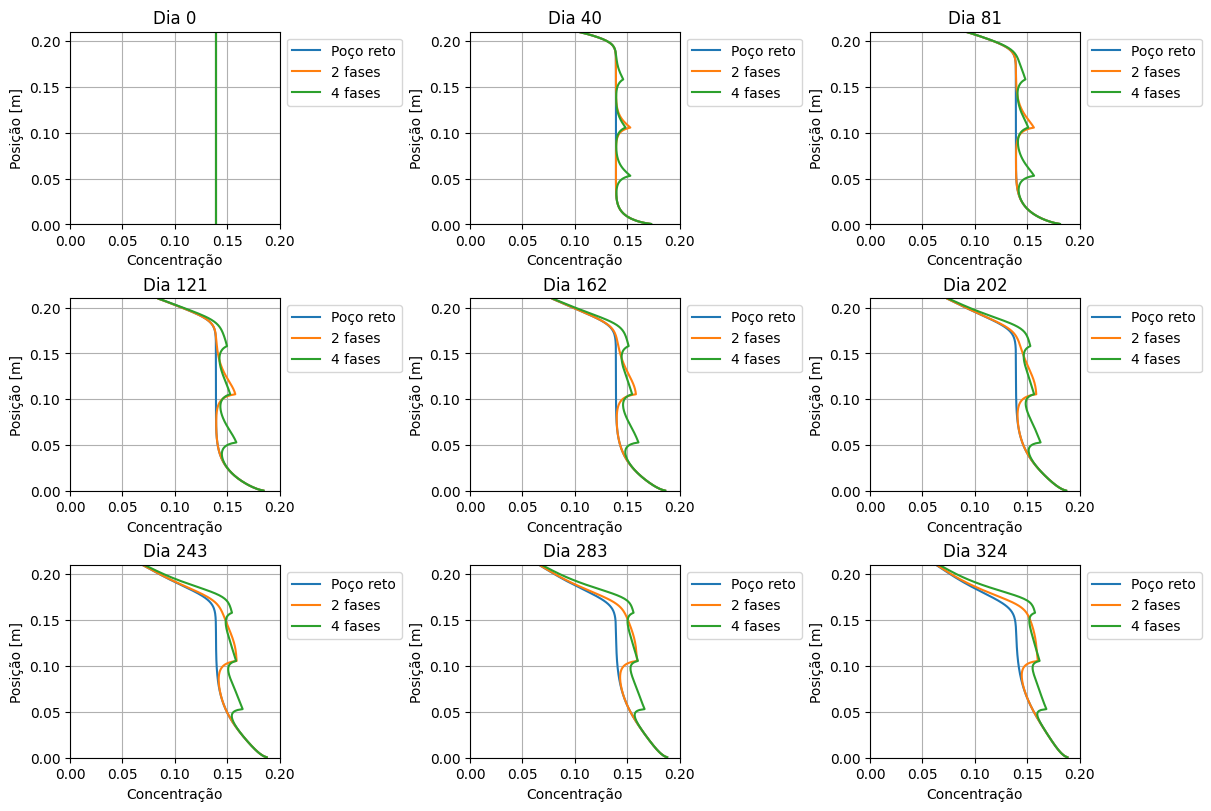

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

target_timeframes = (
    case_data[[k for k in case_data.keys()][0]]["results_handler"]
    .cell_data["Time"]
    .unique()
)
target_timeframes = target_timeframes[:: len(target_timeframes) // 9]

# fig, axs = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)
fig, axs = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)

# for ax, case in zip(axs.flat, case_data.keys()):
for ax, t_time in zip(axs.flat, target_timeframes):
    for case in case_data.keys():
        results_handler = case_data[case]["results_handler"]

        # for position_lbl, concentration_arr in concentration_profiles.items():
        df = results_handler.cell_data
        X = df["Concentration"].loc[df["Time"] == t_time]
        Y = df["Position"].loc[df["Time"] == t_time]
        ax.plot(X, Y, label=case_data[case]["title"])

        ax.set_xlabel("Concentração")
        ax.set_xlim(0, 0.2)
        ax.set_ylabel("Posição [m]")
        ax.set_ylim(0, 0.21)
        ax.grid()
        ax.set_title(f"Dia {int(t_time / (24 * 60 * 60))}")

        ax.legend(bbox_to_anchor=(1, 1))
plt.show()

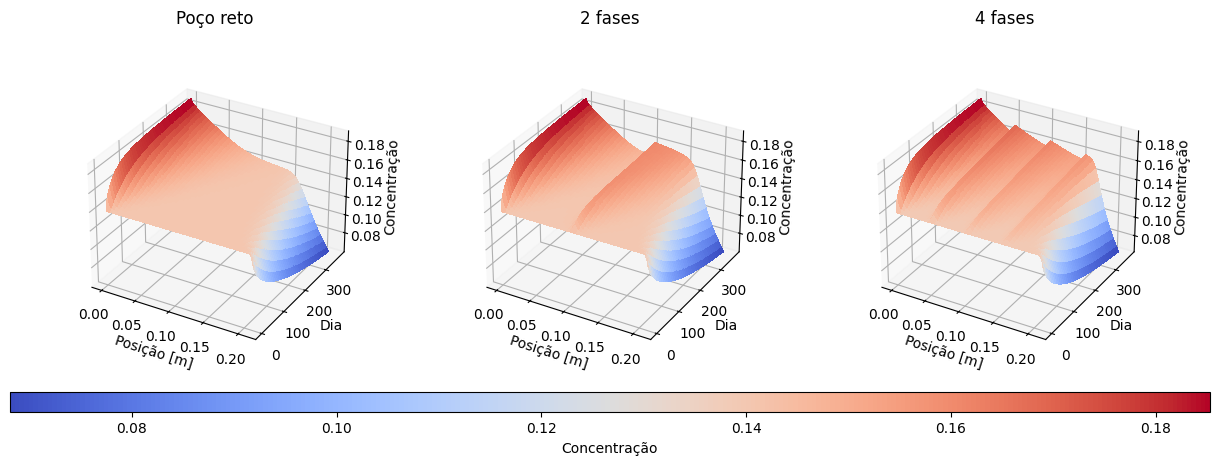

In [53]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

target_positions = [0.005, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12]

fig, axs = plt.subplots(
    min(1, (len(case_data) - 1) // 3 + 1),
    min(3, len(case_data)),
    figsize=(12, 4),
    layout="tight",
    subplot_kw={"projection": "3d"},
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]

    X, Y = np.meshgrid(
        results_handler.cell_data["Position"].unique(),
        results_handler.cell_data["Time"].unique() / (3600 * 24),
    )
    Z = (
        results_handler.cell_data["Concentration"]
        .to_numpy()
        .reshape(
            (
                results_handler.cell_data["Time"].nunique(),
                results_handler.cell_data["Position"].nunique(),
            )
        )
    )

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Posição [m]")
    ax.set_ylabel("Dia")
    ax.set_zlabel("Concentração")
    ax.set_box_aspect(None, zoom=0.8)

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
cbar_ax = fig.add_axes([0, 0, 1, 0.05])
fig.colorbar(
    surf,
    cax=cbar_ax,
    shrink=0.5,
    label="Concentração",
    orientation="horizontal",
)

plt.show()

Plot permeability


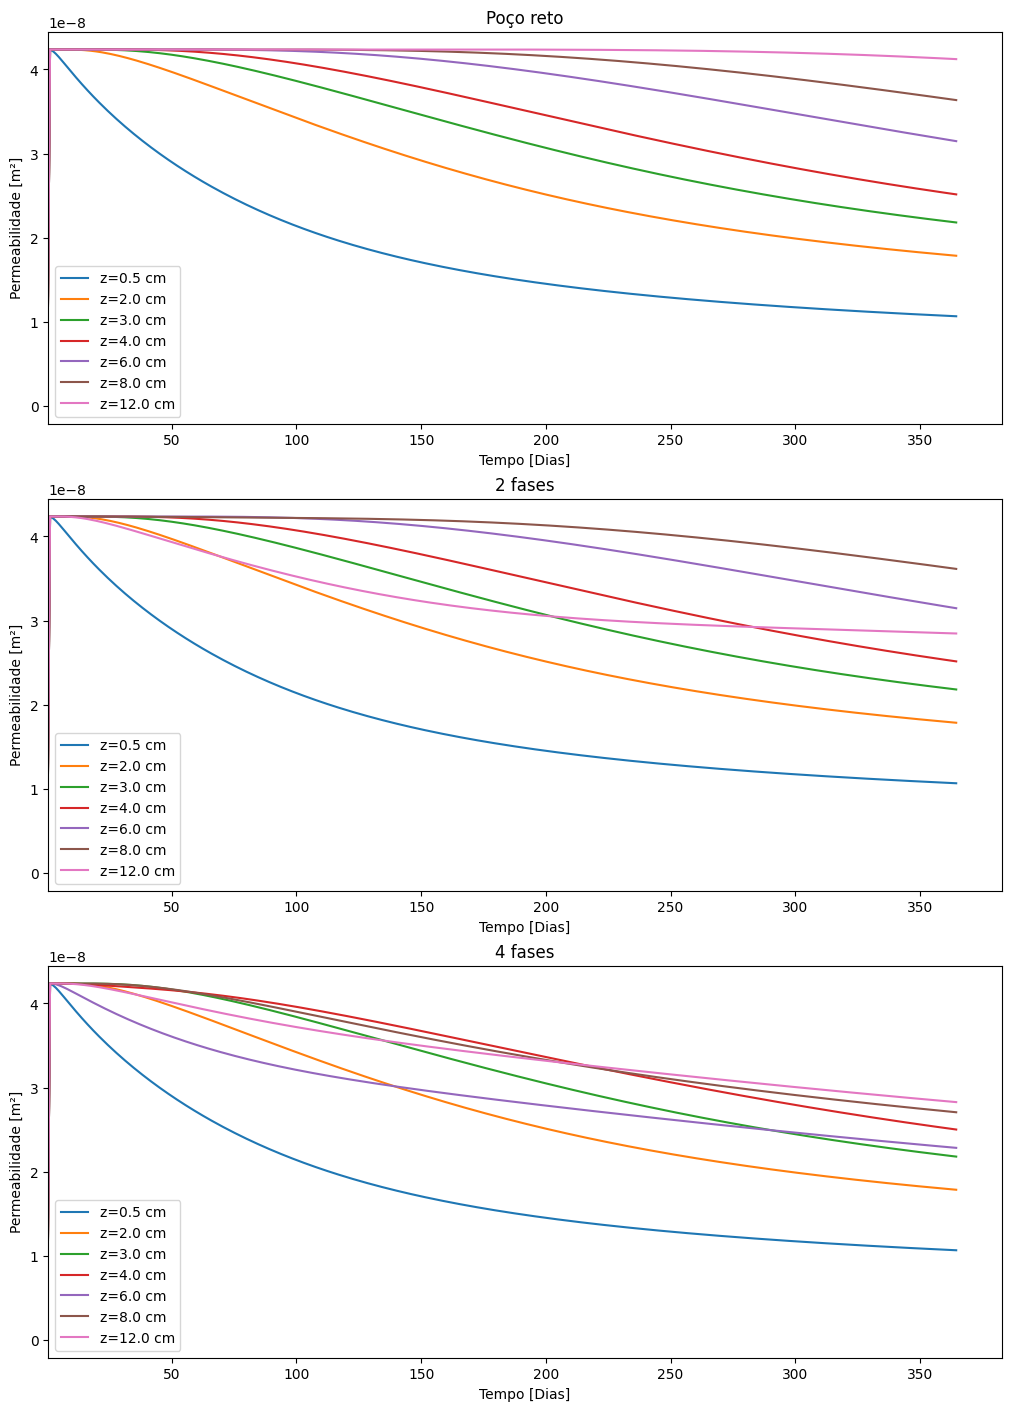

In [54]:
import matplotlib.pyplot as plt

target_positions = [0.005, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12]

fig, axs = plt.subplots(
    min(3, len(case_data)),
    min(1, (len(case_data) - 1) // 3 + 1),
    figsize=(10, 14),
    layout="constrained",
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]

    time, perm_profiles = results_handler.filter_for_positions(
        variable_name="Permeability", position_values=target_positions
    )

    for position_lbl, perm_arr in perm_profiles.items():
        ax.plot(time / (3600 * 24), perm_arr, label=position_lbl)

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Tempo [Dias]")
    ax.set_xlim(0.400)
    ax.set_ylabel("Permeabilidade [m²]")
    ax.legend()
plt.show()

Plot pressure gradient


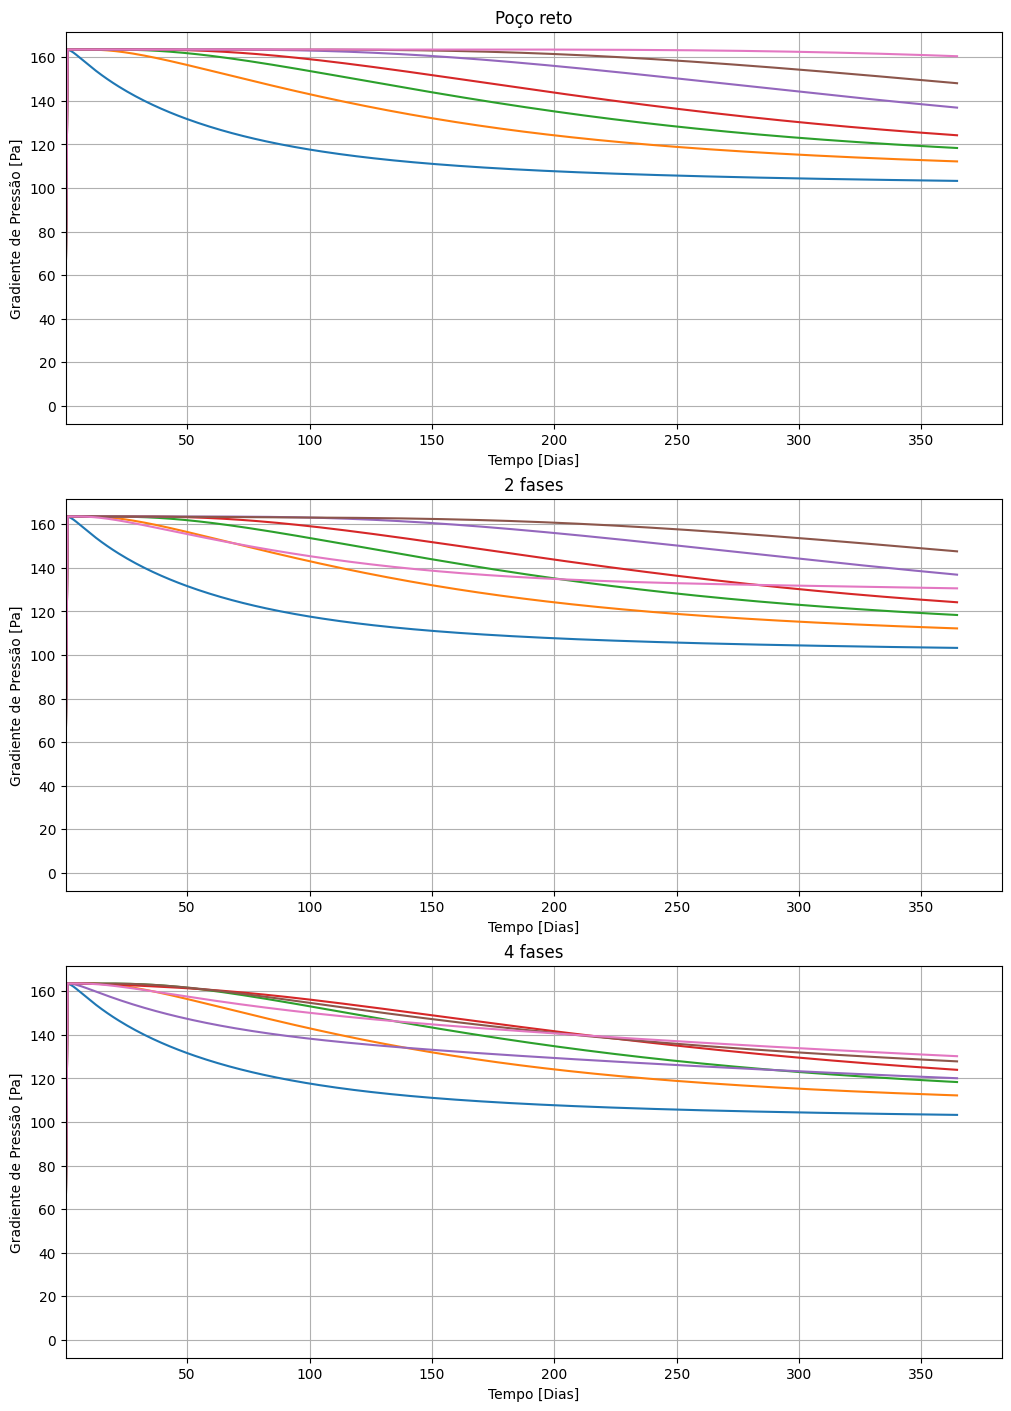

In [55]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    min(3, len(case_data)),
    min(1, (len(case_data) - 1) // 3 + 1),
    figsize=(10, 14),
    layout="constrained",
)

for ax, case in zip(axs.flat, case_data.keys()):
    results_handler = case_data[case]["results_handler"]

    time, pressure_grad_profiles = results_handler.filter_for_positions(
        variable_name="Pressure_Gradient", position_values=target_positions
    )

    for position_lbl, pressure_grad in pressure_grad_profiles.items():
        ax.plot(time / (3600 * 24), pressure_grad, label=position_lbl)

    ax.set_title(case_data[case]["title"])
    ax.set_xlabel("Tempo [Dias]")
    ax.set_xlim(0.400)
    ax.set_ylabel("Gradiente de Pressão [Pa]")
    ax.grid()

    # ax.legend()
plt.show()